In [27]:
import numpy as np

def roll_dice_wild(outcomes):
    return np.random.choice(outcomes, 3).tolist()

def steal_chips(players, current_player, num_chips):
    # Steal chips from other players, favoring players with 3 chips
    total_chips = sum(players) - players[current_player]
    for _ in range(num_chips):
        if total_chips > 0:  # Check if there are any chips left to steal
            # First try to steal from players with 3 chips
            for i in [idx for idx, val in enumerate(players) if val == 3 and idx != current_player]:
                players[current_player] += 1
                players[i] -= 1
                total_chips -= 1
                break
            else:  # If no players with 3 chips, steal from the first player with chips
                for i in reversed(range(len(players))):
                    if i != current_player and players[i] > 0:
                        players[current_player] += 1
                        players[i] -= 1
                        total_chips -= 1
                        break

def play_lcr_wild(num_players, outcomes):
    players = [3] * num_players  # Each player starts with 3 tokens
    pot = 0  # Tokens in the center
    current_player = 0
    turns = 0
    rounds = 0

    pot_history = []  # List to keep track of players who got 3 wilds

    while players.count(0) < num_players - 1:  # Continue until only one player has tokens left
        turns += 1
        if current_player == 0:
            rounds += 1
        num_dice = min(players[current_player], 3)  # Player can roll up to 3 dice
        roll = roll_dice_wild(outcomes)[:num_dice]
        if roll.count('W') == 3:
            players[current_player] += pot
            pot_history.append((current_player, pot, turns, rounds))  # Add the player and the pot size to the history
            pot = 0
        else:
            for outcome in roll:
                if outcome == 'L':
                    players[current_player] -= 1
                    players[(current_player - 1) % num_players] += 1
                elif outcome == 'R':
                    players[current_player] -= 1
                    players[(current_player + 1) % num_players] += 1
                elif outcome == 'C':
                    players[current_player] -= 1
                    pot += 1
                elif outcome == 'W':
                    steal_chips(players, current_player, 1)
        current_player = (current_player + 1) % num_players
        

    winner = players.index(max(players))
    return winner, pot, turns / 6, rounds, pot_history

# Simulate a game with N players
N = 15
winner, pot, turns, rounds, _ = play_lcr_wild(N, ['L', 'R', 'C', '.', '.', '.'])
print(f"Standard: Player {winner + 1} won with {pot} tokens in the pot after {turns} minutes and {rounds} rounds!")
winner, pot, turns, rounds, pot_history  = play_lcr_wild(N, ['L', 'R', 'C', '.', '.', 'W'])
print(f"Wild: Player {winner + 1} won with {pot} tokens in the pot after {turns} minutes and {rounds} rounds!")
#for player, pot, rounds in pot_history:
#    print(f"Player {player + 1} got a pot of size {pot} in round {rounds}")



Standard: Player 8 won with 43 tokens in the pot after 38.666666666666664 minutes and 16 rounds!
Wild: Player 6 won with 5 tokens in the pot after 36.0 minutes and 15 rounds!


In [34]:
import matplotlib.pyplot as plt

# Simulate the game many times for given number of players and provide boxplots
num_simulations = 300
rounds_dict = {num_players: [] for num_players in range(3, 31, 3)}
rounds_dict_wild = {num_players: [] for num_players in range(3, 31, 3)}  # For the wild version

for num_players in rounds_dict:
    for _ in range(num_simulations):
        _, _, turns, rounds, _ = play_lcr_wild(num_players, ['L', 'R', 'C', 'L', 'R', '.'])
        rounds_dict[num_players].append(turns)
        _, _, turns_wild, rounds_wild, _ = play_lcr_wild(num_players, ['L', 'R', 'C', 'L', 'R', 'W'])  # Assuming your play_lcr_wild function returns rounds as the third output
        rounds_dict_wild[num_players].append(turns_wild)


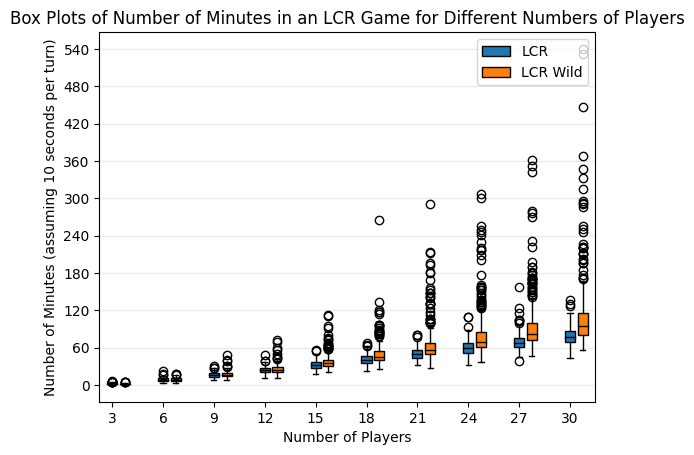

In [37]:
# Create side-by-side box plots of the number of rounds for each number of players
fig, ax = plt.subplots()
# assume 12 turns per minute (5 seconds each)
box_plot_data=[rounds_dict[num_players] for num_players in rounds_dict]
box_plot_data_wild=[rounds_dict_wild[num_players] for num_players in rounds_dict_wild]
positions = np.array(range(len(box_plot_data)))*2.0
positions_wild = positions + 0.5  # Offset the wild version for side-by-side plot

bp1 = ax.boxplot(box_plot_data, positions=positions, widths=0.4, patch_artist=True, boxprops=dict(facecolor="C0"), medianprops=dict(color="black"))
bp2 = ax.boxplot(box_plot_data_wild, positions=positions_wild, widths=0.4, patch_artist=True, boxprops=dict(facecolor="C1"), medianprops=dict(color="black"))

# Set y-axis to go in steps of 15
ax.yaxis.set_ticks(np.arange(0, 600, 60))

# Add a grey grid line across the plot
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

ax.set_xticks(range(0, len(box_plot_data) * 2, 2))
ax.set_xticklabels([str(num_players) for num_players in rounds_dict])

plt.title('Box Plots of Number of Minutes in an LCR Game for Different Numbers of Players')
plt.xlabel('Number of Players')
plt.ylabel('Number of Minutes (assuming 10 seconds per turn)')
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['LCR', 'LCR Wild'], loc='upper right')
plt.show()